In [1]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from data_preprocessing import *
from model import *

In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [4]:
stopword_list = get_stopwords("../marathi-stopwords.txt")

In [5]:
x_train = training_data.text.apply(lambda x: preprocess_data(stopword_list, x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: preprocess_data(stopword_list, x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [6]:
y_train, y_val = label_encoder(y_train, y_val)

In [7]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [8]:
pad_len=100
padding_type='post'
truncating_type='post'

In [9]:
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(x_train, x_val)

In [10]:
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

In [12]:
dump(tokenizer, "../tokenizers/DL-raw-tokenizer-100.pk1")

['../tokenizers/DL-raw-tokenizer-100.pk1']

In [11]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [12]:
vocab = tokenizer.word_index

In [21]:
start = process_time()
embedding_path = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.cleaned.ft.skipgram.d300.vec"
embedding_matrix = get_embedding_matrix(embedding_path, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix.shape

51795
Total time taken:  4.344381335999998


(51802, 300)

In [22]:
input_dim = embedding_matrix.shape[0]
embedding_dim = 300
input_len = pad_len
print("Input vocab: ", input_dim)
print("Embedding dimensions: ", embedding_dim)
print("Input sentence dimensions: ", input_len)

Input vocab:  51802
Embedding dimensions:  300
Input sentence dimensions:  100


In [23]:
myCB = myCallbacks(metrics='acc', threshold=0.95)

# Feed-Forward Neural Network Model

In [26]:
myDNN = create_model_DNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix, 
                         input_len, 
                         trainable=False, 
                         n1=64, n2=32, 
                         kr=l2(0.0))
myDNN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          15540600  
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                19264     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 132       
Total params: 15,562,076
Trainable params: 21,476
Non-trainable params: 15,540,600
_________________________________________________________________


In [27]:
history1 = myDNN.fit(x_train_padded, 
                     y_train, 
                     epochs=8, 
                     batch_size=32, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val))

Epoch 1/8
1313/1313 [==============================] - 9s 7ms/step - loss: 0.7505 - acc: 0.7084 - val_loss: 0.6322 - val_acc: 0.7651
Epoch 2/8
1313/1313 [==============================] - 11s 8ms/step - loss: 0.6042 - acc: 0.7728 - val_loss: 0.6549 - val_acc: 0.7608
Epoch 3/8
1313/1313 [==============================] - 11s 8ms/step - loss: 0.5882 - acc: 0.7797 - val_loss: 0.6169 - val_acc: 0.7698
Epoch 4/8
1313/1313 [==============================] - 11s 8ms/step - loss: 0.5830 - acc: 0.7798 - val_loss: 0.6137 - val_acc: 0.7728
Epoch 5/8
1313/1313 [==============================] - 10s 8ms/step - loss: 0.5725 - acc: 0.7830 - val_loss: 0.6445 - val_acc: 0.7574
Epoch 6/8
1313/1313 [==============================] - 10s 8ms/step - loss: 0.5669 - acc: 0.7865 - val_loss: 0.6222 - val_acc: 0.7701
Epoch 7/8
1313/1313 [==============================] - 10s 7ms/step - loss: 0.5617 - acc: 0.7872 - val_loss: 0.6333 - val_acc: 0.7571
Epoch 8/8
1313/1313 [==============================] - 11s 8ms/

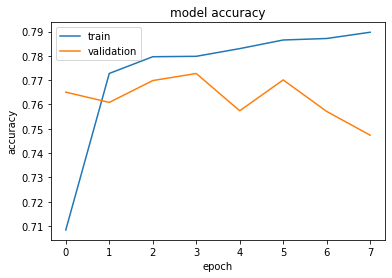

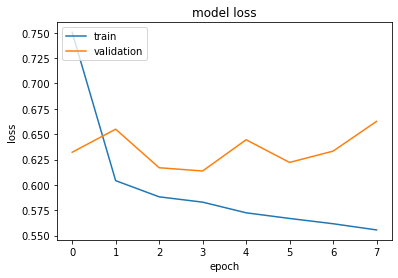

In [28]:
plot_curves(history1)

In [ ]:
name = "FFNN/FFNN-n1.64-n2.32-kr0015-vacc8585"
myDNN.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myDNN.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myDNN.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myDNN = model_load("../models/FFNN/FFNN-n1.64-n2.32-kr0015-vacc8585.h5")

In [29]:
results1 = np.argmax(myDNN.predict(x_val_padded), axis=-1)

In [30]:
acc, precision, recall, f1 = classification_report(y_val, results1)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.7473544973544973

Precision:  [0.68509615 0.69811321 0.85714286 0.81311018]
Average Precision:  0.7633655999617998

Recall:  [0.67857143 0.90963455 0.66440678 0.60103093]
Average nRecall:  0.7134109218906285

F1-Score:  [0.68181818 0.78995961 0.74856779 0.69116775]
Average F1-Score:  0.7278783335148087


# CNN Model

In [31]:
myCNN = create_model_CNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix, 
                         input_len, 
                         trainable=False, 
                         n1=64, k=5, 
                         d=0.25, kr=l2(0.0))
myCNN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 300)          15540600  
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            96064     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 260       
Total params: 15,636,924
Trainable params: 96,324
Non-trainable params: 15,540,600
_________________________________________________________________


In [32]:
history2 = myCNN.fit(x_train_padded, 
                     y_train, 
                     epochs=8, 
                     batch_size=32, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val))

Epoch 1/8
1313/1313 [==============================] - 48s 37ms/step - loss: 0.5085 - acc: 0.8118 - val_loss: 0.4064 - val_acc: 0.8532
Epoch 2/8
1313/1313 [==============================] - 52s 40ms/step - loss: 0.3537 - acc: 0.8709 - val_loss: 0.4046 - val_acc: 0.8484
Epoch 3/8
1313/1313 [==============================] - 52s 40ms/step - loss: 0.2921 - acc: 0.8956 - val_loss: 0.4041 - val_acc: 0.8534
Epoch 4/8
1313/1313 [==============================] - 52s 39ms/step - loss: 0.2378 - acc: 0.9130 - val_loss: 0.4136 - val_acc: 0.8532
Epoch 5/8
1313/1313 [==============================] - 52s 40ms/step - loss: 0.2002 - acc: 0.9274 - val_loss: 0.4487 - val_acc: 0.8487
Epoch 6/8
1313/1313 [==============================] - 54s 41ms/step - loss: 0.1723 - acc: 0.9373 - val_loss: 0.4727 - val_acc: 0.8508
Epoch 7/8
1313/1313 [==============================] - 55s 42ms/step - loss: 0.1542 - acc: 0.9425 - val_loss: 0.4768 - val_acc: 0.8474
Epoch 8/8
1313/1313 [==============================] - 

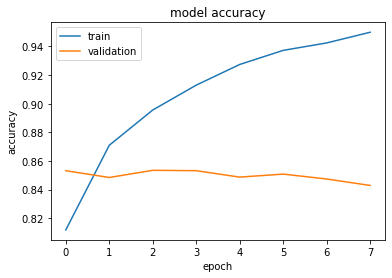

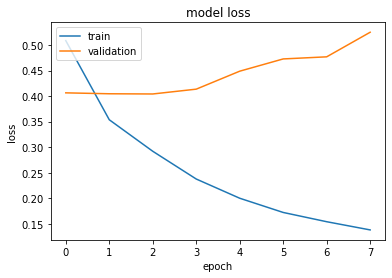

In [33]:
plot_curves(history2)

In [ ]:
name ="CNN/CNN-n1.64n2.64-kr0015-vacc8632"
myCNN.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myCNN.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myCNN.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myCNN = model_load("../models/CNN/CNN-n1.64n2.64-kr0015-vacc8632.h5")

In [34]:
results2 = np.argmax(myCNN.predict(x_val_padded), axis=-1)

In [35]:
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8428571428571429

Precision:  [0.75886525 0.81986834 0.89630513 0.8772137 ]
Average Precision:  0.8380631027703612

Recall:  [0.76428571 0.910299   0.84971751 0.76597938]
Average nRecall:  0.8225704032938915

F1-Score:  [0.76156584 0.8627204  0.87238979 0.81783159]
Average F1-Score:  0.828626905259686


# Bi-LSTM Model

In [36]:
myLSTM = create_model_LSTM(input_dim, 
                           embedding_dim, 
                           embedding_matrix, 
                           input_len, 
                           trainable=False, 
                           n1=64, n2=64, 
                           d=0.3)
myLSTM.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 300)          15540600  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          186880    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 260       
Total params: 15,735,996
Trainable params: 195,396
Non-trainable params: 15,540,600
_________________________________________________________________


In [37]:
history3 = myLSTM.fit(x_train_padded, 
                      y_train, 
                      epochs=8, 
                      batch_size=32, 
                      verbose=1, 
                      validation_data = (x_val_padded, y_val), 
                      callbacks=[myCB])

Epoch 1/8
1313/1313 [==============================] - 288s 219ms/step - loss: 0.4749 - acc: 0.8231 - val_loss: 0.3766 - val_acc: 0.8627
Epoch 2/8
1313/1313 [==============================] - 252s 192ms/step - loss: 0.3751 - acc: 0.8615 - val_loss: 0.3581 - val_acc: 0.8725
Epoch 3/8
1313/1313 [==============================] - 244s 186ms/step - loss: 0.3438 - acc: 0.8729 - val_loss: 0.3470 - val_acc: 0.8672
Epoch 4/8
1313/1313 [==============================] - 260s 198ms/step - loss: 0.3138 - acc: 0.8840 - val_loss: 0.3309 - val_acc: 0.8767
Epoch 5/8
1313/1313 [==============================] - 259s 198ms/step - loss: 0.2867 - acc: 0.8936 - val_loss: 0.3434 - val_acc: 0.8717
Epoch 6/8
1313/1313 [==============================] - 280s 213ms/step - loss: 0.2706 - acc: 0.8989 - val_loss: 0.3385 - val_acc: 0.8733
Epoch 7/8
1313/1313 [==============================] - 356s 271ms/step - loss: 0.2484 - acc: 0.9070 - val_loss: 0.3441 - val_acc: 0.8728
Epoch 8/8
1313/1313 [====================

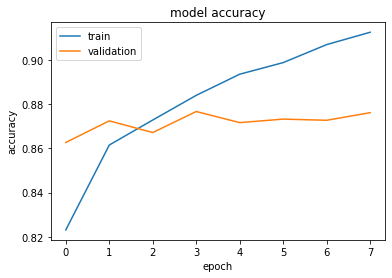

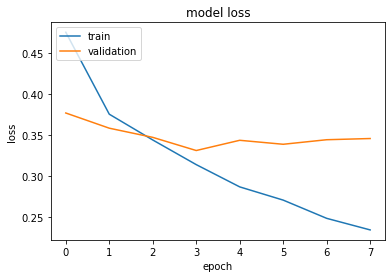

In [38]:
plot_curves(history3)

In [41]:
name= "LSTM/Bi-LST-n1.64-n2.64-d30-f1-8674"
myLSTM.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myLSTM.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myLSTM.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myLSTM = model_load("../models/LSTM/Bi-LST-n1.64-n2.64-kr0015-vacc868.h5")

In [39]:
results3 = np.argmax(myLSTM.predict(x_val_padded), axis=-1)

In [40]:
acc, precision, recall, f1 = classification_report(y_val, results3)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8761904761904762

Precision:  [0.92173913 0.84241706 0.92892157 0.87432868]
Average Precision:  0.8918516098783913

Recall:  [0.75714286 0.9448505  0.85649718 0.83917526]
Average nRecall:  0.8494164470887323

F1-Score:  [0.83137255 0.8906984  0.89124045 0.85639137]
Average F1-Score:  0.8674256928833096
